In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
%pylab inline
from sklearn.metrics import mean_squared_error, mean_absolute_error

Populating the interactive namespace from numpy and matplotlib


C:\Users\SAANKHYA\anaconda3\envs\torch1.7\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
data = pd.read_csv("nasdaq100_padding.csv")

In [5]:
data.shape

(40560, 82)

In [6]:
data.head()

,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,...,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO,NDX
0,35.9800,96.80,97.80,61.15,95.4000,58.180000,58.00,127.040,26.680,165.8100,...,70.73,45.230,31.1701,95.270,81.365,52.16,33.95,48.61,38.010,4665.054
1,35.9310,96.89,97.80,61.61,95.4115,58.190000,58.12,126.060,26.730,165.9101,...,70.69,45.010,31.1900,94.170,81.540,52.15,34.10,48.74,38.140,4665.054
2,35.9044,96.95,97.57,61.98,95.5100,58.203333,57.95,126.510,26.712,166.1800,...,71.30,45.015,31.2100,94.749,81.530,52.27,34.01,48.99,38.150,4665.826
3,35.8900,96.97,97.55,62.09,95.5200,58.216667,57.96,126.280,26.740,166.1480,...,71.31,45.020,31.2100,94.310,81.710,52.30,33.96,48.95,38.195,4667.081
4,36.0080,96.96,97.73,61.89,95.5300,58.230000,58.21,126.585,26.720,165.9900,...,71.06,45.050,31.1800,94.155,81.720,52.30,34.17,48.89,38.320,4664.491


<AxesSubplot:>

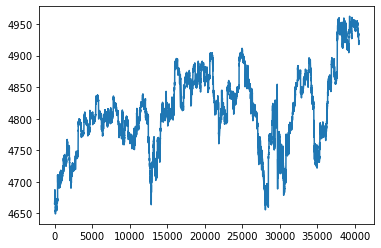

In [7]:
data["NDX"].plot()

In [9]:
batch_size = 128
timesteps = 16
n_timeseries = data.shape[1] - 1
train_length = 35100
val_length = 2730
test_length = 2730
target = "NDX"

In [10]:
X = np.zeros((len(data), timesteps, data.shape[1]-1))
y = np.zeros((len(data), timesteps, 1))
X.shape, y.shape

((40560, 16, 81), (40560, 16, 1))

In [11]:
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(timesteps):
        X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")
X.shape

(40560, 16, 81)

In [12]:
for j in range(timesteps):
    y[:, j, 0] = data["NDX"].shift(timesteps - j - 1).fillna(method="bfill")
y.shape

(40560, 16, 1)

In [23]:
prediction_horizon = 1
target = data["NDX"].shift(-prediction_horizon).fillna(method="ffill").values
target.shape

(40560,)

In [14]:
X = X[timesteps:]
y = y[timesteps:]
target = target[timesteps:]
X.shape, y.shape, target.shape

((40544, 16, 81), (40544, 16, 1), (40544,))

In [18]:
X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

In [19]:
X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)
y_his_train_max = y_his_train.max(axis=0)
y_his_train_min = y_his_train.min(axis=0)
target_train_max = target_train.max(axis=0)
target_train_min = target_train.min(axis=0)

In [20]:
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_val = (X_val - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

y_his_train = (y_his_train - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_val = (y_his_val - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_test = (y_his_test - y_his_train_min) / (y_his_train_max - y_his_train_min)


target_train = (target_train - target_train_min) / (target_train_max - target_train_min)
target_val = (target_val - target_train_min) / (target_train_max - target_train_min)
target_test = (target_test - target_train_min) / (target_train_max - target_train_min)

In [35]:
X_train.shape, y_his_train.shape, target_train.shape

((35100, 16, 81), (35100, 16, 1), (35100,))

In [ ]:
X_train_t = torch.Tensor(X_train).cuda()
X_val_t = torch.Tensor(X_val).cuda()
X_test_t = torch.Tensor(X_test).cuda()
y_his_train_t = torch.Tensor(y_his_train).cuda()
y_his_val_t = torch.Tensor(y_his_val).cuda()
y_his_test_t = torch.Tensor(y_his_test).cuda()
target_train_t = torch.Tensor(target_train).cuda()
target_val_t = torch.Tensor(target_val).cuda()
target_test_t = torch.Tensor(target_test).cuda()

In [ ]:
data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=128)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=128)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=128)

### DARNN

In [ ]:
class InputAttentionEncoder(nn.Module):
    def __init__(self, N, M, T, stateful=False):
        """
        :param: N: int
            number of time serieses
        :param: M:
            number of LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.N = N
        self.M = M
        self.T = T
        
        self.encoder_lstm = nn.LSTMCell(input_size=self.N, hidden_size=self.M)
        
        #equation 8 matrices
        
        self.W_e = nn.Linear(2*self.M, self.T)
        self.U_e = nn.Linear(self.T, self.T, bias=False)
        self.v_e = nn.Linear(self.T, 1, bias=False)
    
    def forward(self, inputs):
        encoded_inputs = torch.zeros((inputs.size(0), self.T, self.M)).cuda()
        
        #initiale hidden states
        h_tm1 = torch.zeros((inputs.size(0), self.M)).cuda()
        s_tm1 = torch.zeros((inputs.size(0), self.M)).cuda()
        
        for t in range(self.T):
            #concatenate hidden states
            h_c_concat = torch.cat((h_tm1, s_tm1), dim=1)
            
            #attention weights for each k in N (equation 8)
            x = self.W_e(h_c_concat).unsqueeze_(1).repeat(1, self.N, 1)
            y = self.U_e(inputs.permute(0, 2, 1))
            z = torch.tanh(x + y)
            e_k_t = torch.squeeze(self.v_e(z))
        
            #normalize attention weights (equation 9)
            alpha_k_t = F.softmax(e_k_t, dim=1)
            
            #weight inputs (equation 10)
            weighted_inputs = alpha_k_t * inputs[:, t, :] 
    
            #calculate next hidden states (equation 11)
            h_tm1, s_tm1 = self.encoder_lstm(weighted_inputs, (h_tm1, s_tm1))
            
            encoded_inputs[:, t, :] = h_tm1
        return encoded_inputs

In [ ]:
class TemporalAttentionDecoder(nn.Module):
    def __init__(self, M, P, T, stateful=False):
        """
        :param: M: int
            number of encoder LSTM units
        :param: P:
            number of deocder LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.M = M
        self.P = P
        self.T = T
        self.stateful = stateful
        
        self.decoder_lstm = nn.LSTMCell(input_size=1, hidden_size=self.P)
        
        #equation 12 matrices
        self.W_d = nn.Linear(2*self.P, self.M)
        self.U_d = nn.Linear(self.M, self.M, bias=False)
        self.v_d = nn.Linear(self.M, 1, bias = False)
        
        #equation 15 matrix
        self.w_tilda = nn.Linear(self.M + 1, 1)
        
        #equation 22 matrices
        self.W_y = nn.Linear(self.P + self.M, self.P)
        self.v_y = nn.Linear(self.P, 1)
        
    def forward(self, encoded_inputs, y):
        
        #initializing hidden states
        d_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).cuda()
        s_prime_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).cuda()
        for t in range(self.T):
            #concatenate hidden states
            d_s_prime_concat = torch.cat((d_tm1, s_prime_tm1), dim=1)
            #print(d_s_prime_concat)
            #temporal attention weights (equation 12)
            x1 = self.W_d(d_s_prime_concat).unsqueeze_(1).repeat(1, encoded_inputs.shape[1], 1)
            y1 = self.U_d(encoded_inputs)
            z1 = torch.tanh(x1 + y1)
            l_i_t = self.v_d(z1)
            
            #normalized attention weights (equation 13)
            beta_i_t = F.softmax(l_i_t, dim=1)
            
            #create context vector (equation_14)
            c_t = torch.sum(beta_i_t * encoded_inputs, dim=1)
            
            #concatenate c_t and y_t
            y_c_concat = torch.cat((c_t, y[:, t, :]), dim=1)
            #create y_tilda
            y_tilda_t = self.w_tilda(y_c_concat)
            
            #calculate next hidden states (equation 16)
            d_tm1, s_prime_tm1 = self.decoder_lstm(y_tilda_t, (d_tm1, s_prime_tm1))
        
        #concatenate context vector at step T and hidden state at step T
        d_c_concat = torch.cat((d_tm1, c_t), dim=1)

        #calculate output
        y_Tp1 = self.v_y(self.W_y(d_c_concat))
        return y_Tp1

In [ ]:
class DARNN(nn.Module):
    def __init__(self, N, M, P, T, stateful_encoder=False, stateful_decoder=False):
        super(self.__class__, self).__init__()
        self.encoder = InputAttentionEncoder(N, M, T, stateful_encoder).cuda()
        self.decoder = TemporalAttentionDecoder(M, P, T, stateful_decoder).cuda()
    def forward(self, X_history, y_history):
        out = self.decoder(self.encoder(X_history), y_history)
        return out

In [22]:
model = DARNN(X_train.shape[2], 64, 64, X_train.shape[1]).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

Saving...
Iter:  0 train:  0.15281611945015025 val:  0.03789392116252552
mse:  98.83054 mae:  8.469264


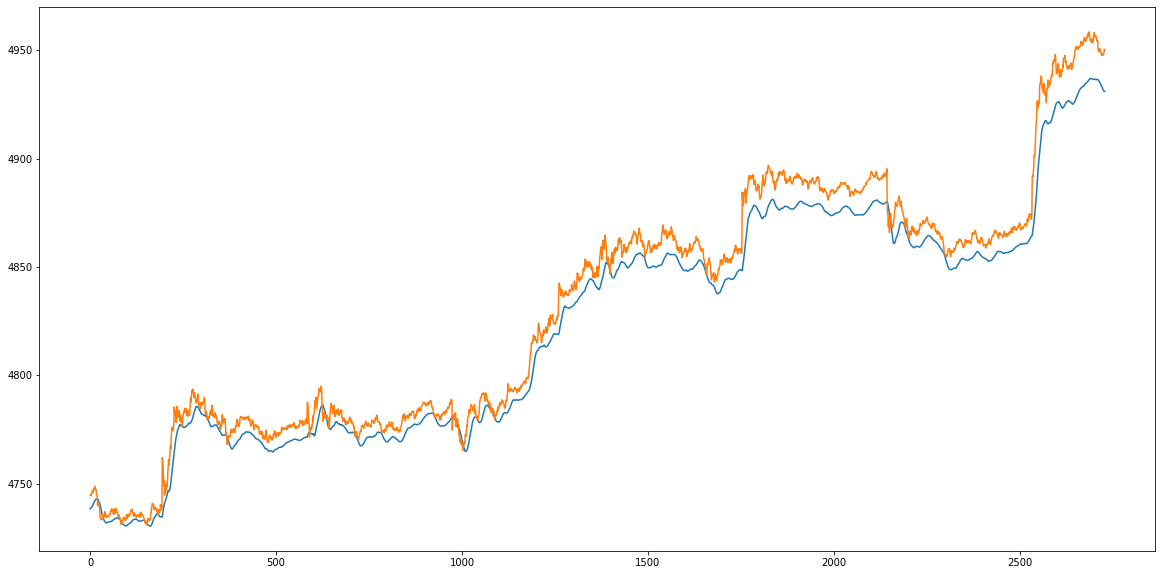

Saving...
Iter:  1 train:  0.01754429748691016 val:  0.029871716077650608
Saving...
Iter:  2 train:  0.01674907608473586 val:  0.02041298785597127
Iter:  3 train:  0.015649243278740482 val:  0.024705782990594234
Iter:  4 train:  0.014636983524956805 val:  0.023041375481759305
Saving...
Iter:  5 train:  0.01367718937336265 val:  0.014916447539405086
Iter:  6 train:  0.013085394058251104 val:  0.016172477369427788
Iter:  7 train:  0.011963992042971753 val:  0.019512058521989638
Saving...
Iter:  8 train:  0.011434274419150339 val:  0.012577368906175444
Iter:  9 train:  0.010275968390920907 val:  0.023291345024281287
Iter:  10 train:  0.009918818556939666 val:  0.014062971103964357
mse:  13.611496 mae:  2.9058156


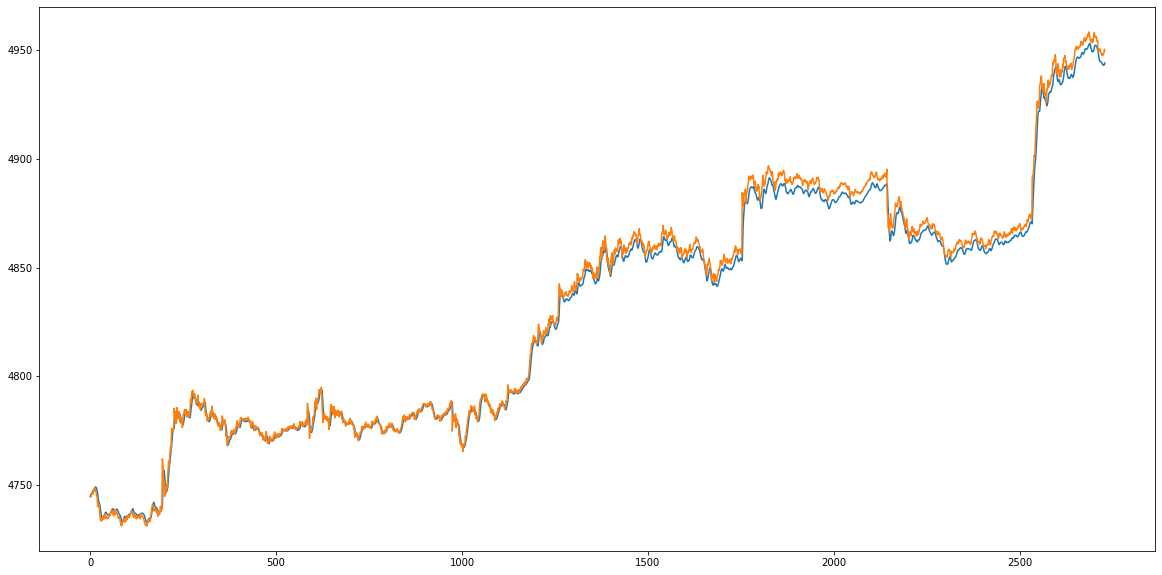

Saving...
Iter:  11 train:  0.00941277265121887 val:  0.011542549287276408
Iter:  12 train:  0.00921456766128174 val:  0.016371268769049468
Saving...
Iter:  13 train:  0.00885293348839667 val:  0.011192707889111506
Iter:  14 train:  0.008744735702497114 val:  0.019675178659577446
Saving...
Iter:  15 train:  0.008324659714887417 val:  0.009509511560911286
Iter:  16 train:  0.008198001133150808 val:  0.010323522963372606
Iter:  17 train:  0.008248328961232137 val:  0.009889023466162552
Saving...
Iter:  18 train:  0.00794318634230761 val:  0.0070972953736820775
Iter:  19 train:  0.008175033150059881 val:  0.011771431796510795
Iter:  20 train:  0.007416643474742883 val:  0.009279949059488597
mse:  5.9271317 mae:  1.8853841


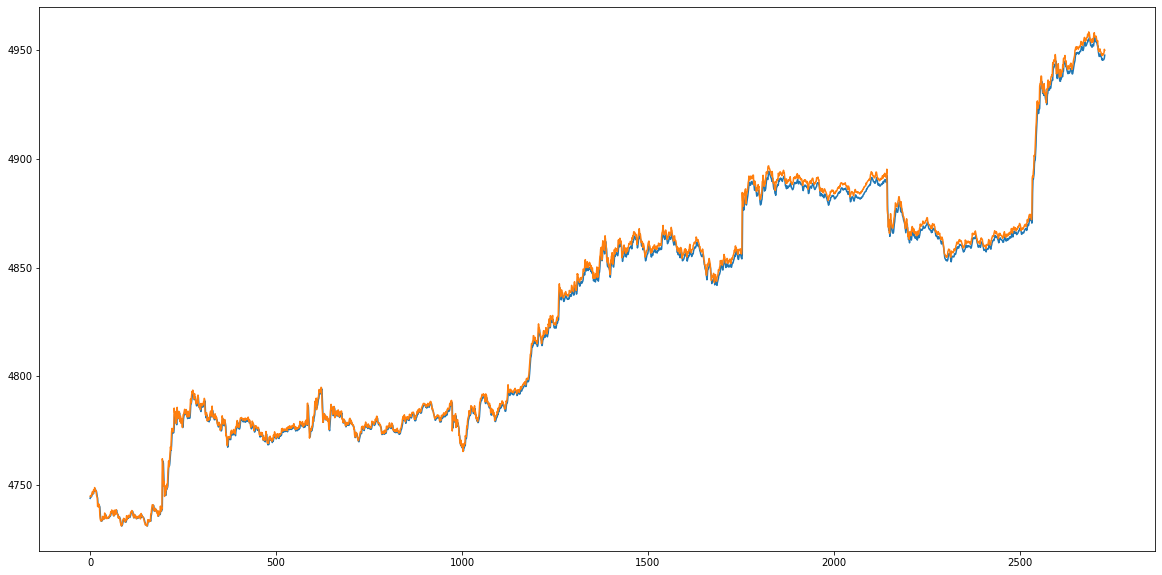

Iter:  21 train:  0.0072797625204520456 val:  0.008309785774409856
Iter:  22 train:  0.00729659209124668 val:  0.010026771811032214
Saving...
Iter:  23 train:  0.0072101277868921445 val:  0.007077977673659115
Iter:  24 train:  0.007165125666190382 val:  0.00805312403697227
Iter:  25 train:  0.007361122535356992 val:  0.009235048219566212
Iter:  26 train:  0.007255734192831672 val:  0.008619543484843676
Saving...
Iter:  27 train:  0.007384052870051392 val:  0.006571022253277214
Iter:  28 train:  0.007111373762676655 val:  0.009145752505950804
Iter:  29 train:  0.007025979731502257 val:  0.015149594545968662
Iter:  30 train:  0.007010424589978251 val:  0.00676189681528482
mse:  3.1469433 mae:  1.1973495


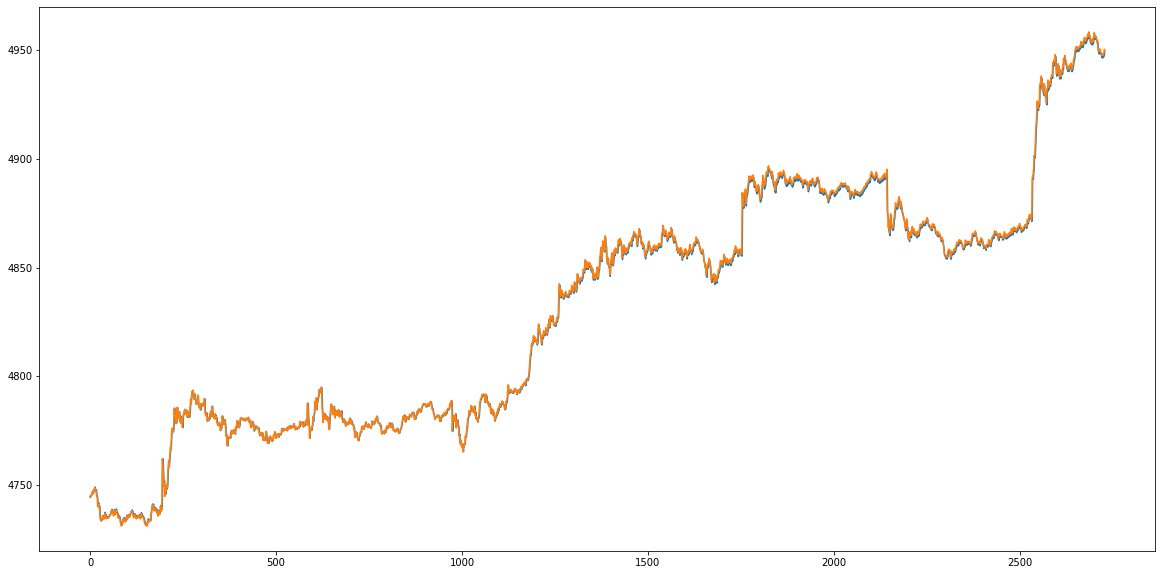

Saving...
Iter:  31 train:  0.007458969554234453 val:  0.00651793551630779
Iter:  32 train:  0.0070223995109863525 val:  0.007554768100792708
Saving...
Iter:  33 train:  0.006875447669733342 val:  0.006278614058763458
Iter:  34 train:  0.007143955037829572 val:  0.0068828614280727835
Iter:  35 train:  0.006849992771676808 val:  0.007325974934410509
Iter:  36 train:  0.0070821798880676854 val:  0.0071321398315890095
Iter:  37 train:  0.007027518319074103 val:  0.009011573756339947
Iter:  38 train:  0.006969056355275019 val:  0.01251468810005152
Saving...
Iter:  39 train:  0.007061086623221018 val:  0.006206880207071423
Iter:  40 train:  0.007099843878924693 val:  0.00671756863740363
mse:  3.1057992 mae:  1.1983583


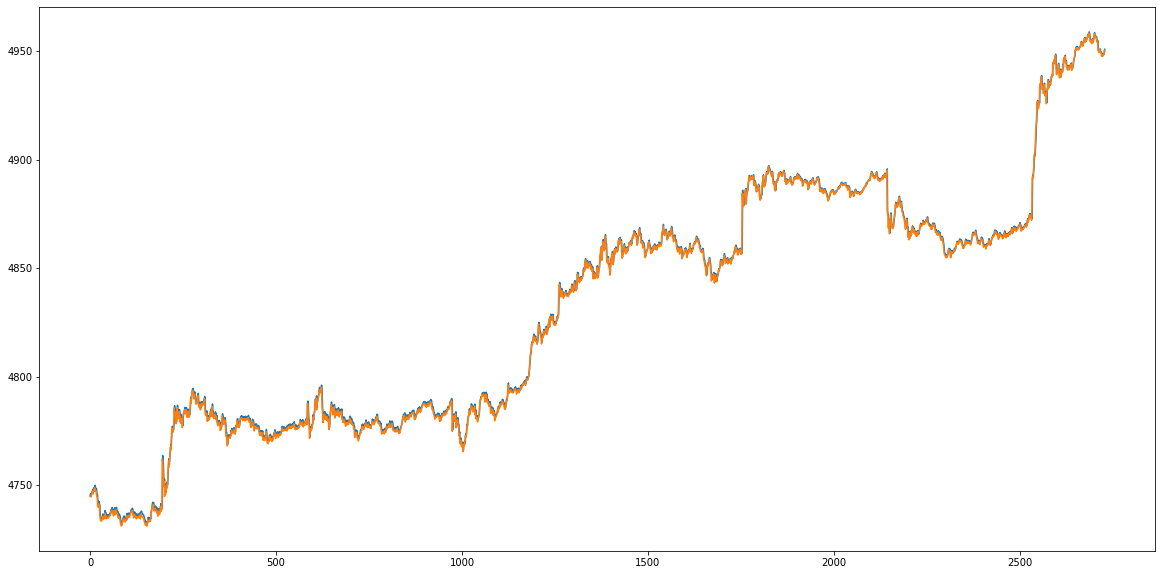

Iter:  41 train:  0.00679052551949132 val:  0.0076499081360698355
Iter:  42 train:  0.006788937971463484 val:  0.007295427577096387
Iter:  43 train:  0.006814442197000237 val:  0.008163628798442905
Iter:  44 train:  0.007075405526681492 val:  0.007738858445118127
Iter:  45 train:  0.006901645113791821 val:  0.006758380784647118
Iter:  46 train:  0.006907358276680029 val:  0.01092044729468712
Iter:  47 train:  0.006984702649370431 val:  0.007656251046347838
Iter:  48 train:  0.006744202143852235 val:  0.006307820680752984
Iter:  49 train:  0.006823287467239086 val:  0.006859796329715537
Iter:  50 train:  0.006841337037057839 val:  0.00914884323166336
mse:  5.760834 mae:  1.9410775


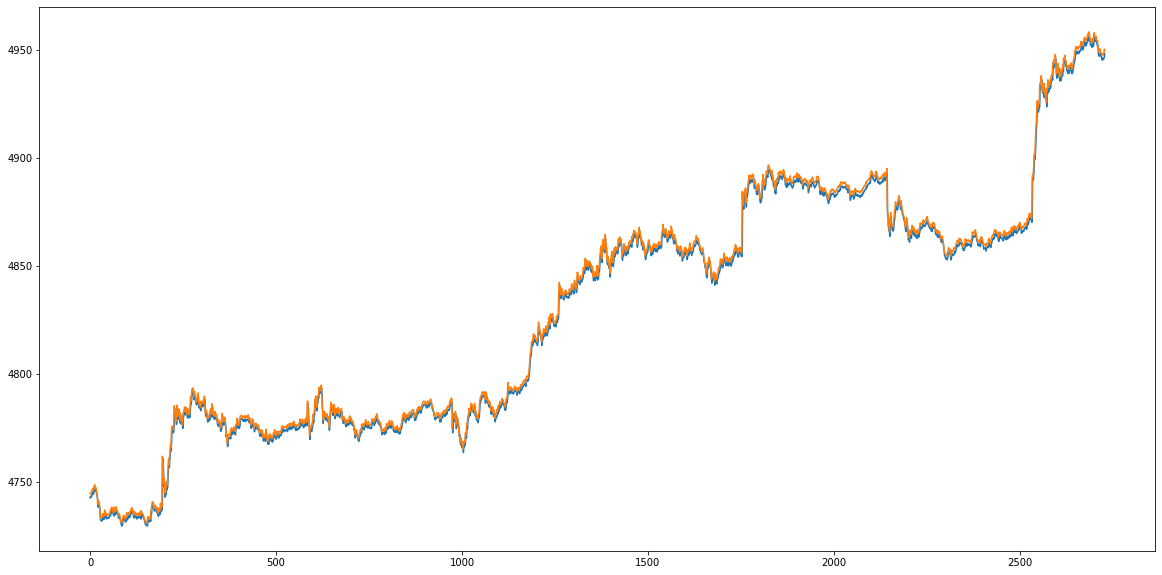

In [27]:
epochs = 51
loss = nn.MSELoss()
patience = 15
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y_h, batch_y in data_train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        opt.zero_grad()
        y_pred = model(batch_x, batch_y_h)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in data_val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_h = batch_y_h.cuda()
            output = model(batch_x, batch_y_h)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "darnn_nasdaq.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    if(i % 10 == 0):
        preds = preds*(target_train_max - target_train_min) + target_train_min
        true = true*(target_train_max - target_train_min) + target_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [28]:
model.load_state_dict(torch.load("darnn_nasdaq.pt"))

<All keys matched successfully>

In [29]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y_h, batch_y in data_test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        output = model(batch_x, batch_y_h)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

C:\Users\SAANKHYA\anaconda3\envs\pytorch_env\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\SAANKHYA\anaconda3\envs\pytorch_env\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [30]:
preds = preds*(target_train_max - target_train_min) + target_train_min
true = true*(target_train_max - target_train_min) + target_train_min

In [31]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [32]:
mse, mae

(2.0318317, 0.91284376)

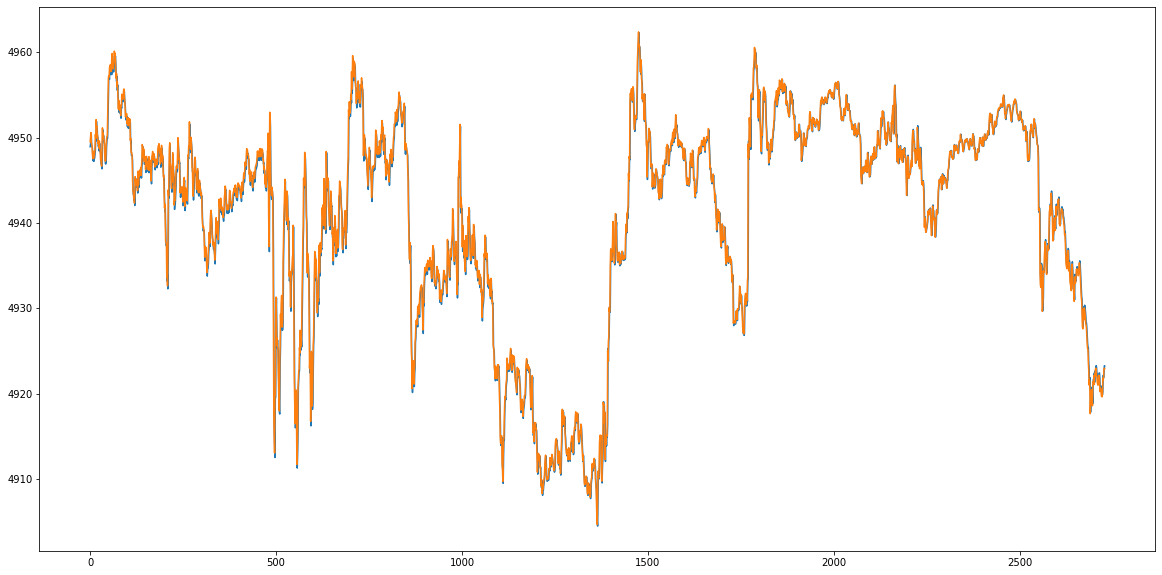

In [33]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()